# Recreating Ling _IMMI_ (2017)
In this notebook, we will recreate some key results from [Ling et al. _IMMI_ (2017)](https://link.springer.com/article/10.1007/s40192-017-0098-z), which studied the application of random-forest-based uncertainties to materials design. We will show that the errors produced from the Random Forest implemented in lolo (the code used by Ling et al.) are well-calibrated and that the uncertainties can be used with Sequential Learning to quickly find optimal materials within a search space.

Note: This notebook will require you to install [lolopy](https://pypi.org/project/lolopy/) and establish an account with Citrination to get an an API key (see [Quickstart](https://citrineinformatics.github.io/api-documentation/quickstart/index.html)), and set it as an environment variable named CITRINE_KEY. Also, the uncertainity calculations do not currently function on Windows. 

Last used with matminer version 0.4.5.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matminer.data_retrieval.retrieve_Citrine import CitrineDataRetrieval
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from lolopy.learners import RandomForestRegressor
from sklearn.model_selection import KFold
from pymatgen import Composition
from scipy.stats import norm
import pandas as pd
import numpy as np
import os

Set the random seed

In [2]:
np.random.seed(8)

## Get the Datasets
The Ling Paper used 4 different datasets to test the uncertainty estimates

In [3]:
cdr = CitrineDataRetrieval()

In [4]:
data = cdr.get_dataframe(criteria={'data_set_id': 150888}, print_properties_options=False)

100%|██████████| 165/165 [00:03<00:00, 46.07it/s]


Convert the composition and class variable from strings

In [5]:
data = StrToComposition(target_col_id='composition').featurize_dataframe(data, "chemicalFormula")

HBox(children=(IntProgress(value=0, description='StrToComposition', max=165), HTML(value='')))

In [6]:
data['ZT'] = pd.to_numeric(data['ZT'], errors='coerce')

In [7]:
data.reset_index(drop=True, inplace=True)

## Compute Features
Every dataset except the steel fatigue dataset uses the composition-based features of [Ward et al.](https://www.nature.com/articles/npjcompumats201628).

In [8]:
f =  MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                         cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])

In [9]:
X = np.array(f.featurize_many(data['composition']))

HBox(children=(IntProgress(value=0, description='MultipleFeaturizer', max=165), HTML(value='')))

## Get the Residuals and RF Uncertainty
As described in the Ling paper, ideally-calibrated uncertainty estimaes should have a particular relationship with the errors of a machine learning model. Specifically, the distribution of $r(x)/\sigma(x)$ where $r(x)$ is the residual of the prediction and $\sigma(x)$ is the uncertainty of the prediction for x should have a Gaussian distribution with zero mean and unit standard deviation.

In [10]:
model = RandomForestRegressor()

Get the errors from 8-fold cross-validation

In [11]:
y = data['ZT'].values

In [12]:
y_resid = []
y_uncer = []
for train_id, test_id in KFold(8, shuffle=True).split(X):
    model.fit(X[train_id], y[train_id])
    yf_pred, yf_std = model.predict(X[test_id], return_std=True)
    y_resid.extend(yf_pred - y[test_id])
    y_uncer.extend(yf_std)

Plot the normalized residuals ($r(x)/\sigma(x)$) against the normal distribution

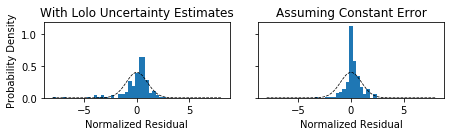

In [13]:
fig, axs = plt.subplots(1, 2, sharey=True)

x = np.linspace(-8, 8, 50)

# Plot the RF uncertainty
resid = np.divide(y_resid, y_uncer)
axs[0].hist(resid, x, density=True)
axs[0].set_title('With Lolo Uncertainty Estimates')

# Plot assuming constant errors
resid = np.divide(y_resid, np.sqrt(np.power(y_resid, 2).mean()))
axs[1].hist(resid, x, density=True)
axs[1].set_title('Assuming Constant Error')

for ax in axs:
    ax.plot(x, norm.pdf(x), 'k--', lw=0.75)
    ax.set_xlabel('Normalized Residual')

axs[0].set_ylabel('Probability Density')

fig.set_size_inches(6.5, 2)
fig.tight_layout()

Here, we compare the error distribution using the Lolo uncertainty estimates (_left_) and the assumption that all entries have the same error (_right_). The normalized residuals for the uncertainty estimates have a distribution closer to the unit normal distribution, which means - as expected - that it better captures which predictions will have a higher error.

## Sequential Learning
One important use of model uncertainties is to employ them to guide which experiments to pick to find optimal materials with minimal experiments/computations. As described in the Ling paper (and [other](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.89.054303) [nice](https://www.nature.com/articles/srep19660) [articles](https://link.springer.com/article/10.1007/s10822-015-9832-9)), it is not always best to pick the experiment that the model predicts to have the best properties if you can perform more than one experiment sequentially. Rather, it can be better to pick entries with large uncertainities that, when tested and added to the training set, can improve the models predictions for the next experiments. 

Here, we demonstrate one approach for picking experiments: Maximum Liklihood of Improvement (MLI). In contrast to picking the material with the best predicted properties (an approach we refer to Maximum Expected Improvment (MEI)), the MLI approach pickes the material with with the highest liklihood of being better than the best material in the training set - a measure that uses both the predicted value and the uncertainty. The MLI  method is equivalent to the [Expected Improvement metric common in Bayesian Optimization](https://sigopt.com/blog/expected-improvement-vs-knowledge-gradient), and balances a tradeoff between picking entries with favorable predictions (*exploitation*) and those with high uncertainties (*exploration*).

### Step 1: Pick an initial training set
We'll start with a small set of entries from the training set

In [14]:
in_train = np.zeros(len(data), dtype=np.bool)
in_train[np.random.choice(len(data), 10, replace=False)] = True
print('Picked {} training entries'.format(in_train.sum()))

Picked 10 training entries


In [15]:
assert not np.isclose(max(y), max(y[in_train]))

### Step 2: Demonstrate picking the entries based on MLI and MEI
Just to give a visual of how the selection process works

Make the predictions

In [16]:
model.fit(X[in_train], y[in_train])
y_pred, y_std = model.predict(X[~in_train], return_std=True)

For MEI, we pick the highest predicted value. For MLI, we pick the material that has the highest probability of being better than any material in the training set. As we assume the predictions to be normally distributed, the probability of materials can be computed from the [Z-score](https://en.wikipedia.org/wiki/Standard_score) $Z = (y - y^*)/\sigma$ where $y^*$ is the maximum of the $y$ of the training set. Formally, the probability can be computed from the Z-score using the cumulative distribution function of the normal distribution. For our purposes, we can use the Z-score becuase the probability is a monotonic function of the Z-score (stated simply: the material with the highest probability will have the highest Z-score).

In [17]:
mei_selection = np.argmax(y_pred)
mli_selection = np.argmax(np.divide(y_pred - np.max(y[in_train]), y_std))

In [18]:
print('Predicted ZT of material #{} selected based on MEI: {:.2f} +/- {:.2f}'.format(mei_selection, y_pred[mei_selection], y_std[mei_selection]))
print('Predicted ZT of material #{} selected based on MLI: {:.2f} +/- {:.2f}'.format(mli_selection, y_pred[mli_selection], y_std[mli_selection]))

Predicted ZT of material #13 selected based on MEI: 0.14 +/- 0.08
Predicted ZT of material #1 selected based on MLI: 0.12 +/- 0.12


For this particular iteration, the MEI and MLI strategies pick the same material. Depending on the random seed of this notebook and that used by lolo, you may see that the material picked by MLI has a lower predicted $ZT$ but a higher variance. According to the logic behind MLI, picking that entry will (1) yield a higher liklihood of finding a well-performing material and (2) lead to an improved model.

### Step 3: Run an iterative search
Starting with the same 32 materials in the training set, we will iteratively pick materials, add them to the training set, and retrain the model using 3 different strategies for picking entries: MEI, MLI, and randomly.

In [19]:
n_steps = 32

In [20]:
all_inds = set(range(len(y)))

#### Random Selection
Just pick an entry at random, no need to train a model

In [21]:
random_train = [set(np.where(in_train)[0].tolist())]

In [22]:
for i in range(n_steps):
    # Get the current train set and search space
    train_inds = set(random_train[-1])  # Last iteration
    search_inds = sorted(all_inds.difference(train_inds))
    
    # Pick an entry at random
    train_inds.add(np.random.choice(search_inds))
    
    # Add it to the list of training sets
    random_train.append(train_inds)

#### Maximum Expected Improvement
Pick the entry with the largest predicted value

In [23]:
mei_train = [set(np.where(in_train)[0].tolist())]

In [24]:
for i in range(n_steps):
    # Get the current train set and search space
    train_inds = sorted(set(mei_train[-1]))  # Last iteration
    search_inds = sorted(all_inds.difference(train_inds))
    
    # Pick entry with the largest maximum value
    model.fit(X[train_inds], y[train_inds])
    y_pred = model.predict(X[search_inds])
    train_inds.append(search_inds[np.argmax(y_pred)])
    
    # Add it to the list of training sets
    mei_train.append(set(train_inds))

#### Maximum Likelihood of Improvement
Pick the entry with the largest probability of improvement

In [25]:
mli_train = [set(np.where(in_train)[0].tolist())]

In [26]:
for i in range(n_steps):
    # Get the current train set and search space
    train_inds = sorted(set(mei_train[-1]))  # Last iteration
    search_inds = sorted(all_inds.difference(train_inds))
    
    # Pick entry with the largest maximum value
    model.fit(X[train_inds], y[train_inds])
    y_pred, y_std = model.predict(X[search_inds], return_std=True)
    train_inds.append(search_inds[np.argmax(np.divide(y_pred - np.max(y[train_inds]), y_std))])
    
    # Add it to the list of training sets
    mli_train.append(set(train_inds))

Plot the results

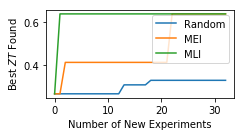

In [27]:
fig, ax = plt.subplots()

for train_inds, label in zip([random_train, mei_train, mli_train], ['Random', 'MEI', 'MLI']):
    ax.plot(np.arange(len(train_inds)), [max(y[list(t)]) for t in train_inds], label=label)

ax.set_xlabel('Number of New Experiments')
ax.set_ylabel('Best $ZT$ Found')
    
fig.set_size_inches(3.5, 2)
ax.legend()
fig.tight_layout()

For this particular case, we find that the MLI strategy finds the best material more quickly than the Random or MEI approaches. In Ling 2017, they evaluate the performance of these strategies over many iterations and find that, on average, MLI finds the optimal materials as fast or better than any other approach. 